In [106]:
import numpy as np

In [107]:
def min_time_solution(x, time_step, discount_factor=1):
    # Caveat: this does not take the zero-order hold on u into account

    q = x[0, :]
    qdot = x[1, :]
    # mask indicates that we are in the regime where u = +1.
    mask = ((qdot < 0) & (2 * q <= (qdot**2))) | (
        (qdot >= 0) & (2 * q < -(qdot**2))
    )
    T = np.empty(q.size)
    T[mask] = 2 * np.sqrt(0.5 * qdot[mask] ** 2 - q[mask]) - qdot[mask]
    T[~mask] = qdot[~mask] + 2 * np.sqrt(0.5 * qdot[~mask] ** 2 + q[~mask])

    if discount_factor == 1:
        return T
    else:
        # discount in continuous time looks like e^(-t/tau), with e^(-time_step/tau) = discount_factor; or -time_step/tau = ln(discount_factor)
        tau = -time_step / np.log(discount_factor)
        # ∫₀ᵀ exp(−t/τ) dt = τ [1 − exp(-T/τ)]
        return tau * (1 - np.exp(-T / tau))

In [124]:
target_pos = 1
x_0 = np.array([[-target_pos], [0]])  # init error
np.set_printoptions(precision=10)
T_star = min_time_solution(x = x_0,time_step=0.1,discount_factor=1)
print((T_star))

[2.]


# Double Integrator Minimum Time Optimization (Bang-Bang Control)

In [128]:
# Generate data for control problem.
import numpy as np

np.random.seed(1)
dt = 0.1  #sampling time
T_star = 20    # minimum time soluton
T = T_star    #horizon
m = 1     #mass
c = 0    #damping

umax = 1 #control limits

#Euler integrated system
A = np.eye(2) + dt * np.array([[0, 1], [0, -c/m]])
print("A mat",A)
B = dt* np.array([[0], [1/m]])
print("B mat",B)
(nx, nu) = B.shape

target_pos = 1
x_0 = np.array([[-target_pos], [0]])  # init error
# x_0 = 1e3*np.random.randn(nx)
x_N = np.array([[0], [0]]) # final error


# alpha to get an exponentially increasing discounted cost or decreasing discounted reward
alpha = 0.02



A mat [[1.  0.1]
 [0.  1. ]]
B mat [[0. ]
 [0.1]]


In [129]:
# Form and solve control problem.
import cvxpy as cp


x = cp.Variable((nx, T + 1))
u = cp.Variable((nu, T))

cost = 0
constr = []
for t in range(T):
    # cost +=  cp.sum_squares(x[:, t + 1]) + cp.sum_squares(u[:, t])
    # cost *= np.exp(alpha*t) 
    cost+= t
    constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t], cp.norm(u[:, t], "inf") <= umax]
        
# sums problem objectives and concatenates constraints.
constr += [x[:, T] == 0, x[:, 0] == x_0[:,0]]

#solve
problem = cp.Problem(cp.Minimize(cost), constr)
problem.solve(verbose=False,solver='SCS')

190.0

error
[9.9999999917e-01 9.9999999791e-01 9.8999997899e-01 9.6999993261e-01
 9.3999984900e-01 8.9999975888e-01 8.4999974567e-01 7.8999987248e-01
 7.2000017601e-01 6.4000043424e-01 5.5000020218e-01 4.4999977349e-01
 3.5999954510e-01 2.7999980593e-01 2.1000011226e-01 1.5000024191e-01
 1.0000023133e-01 6.0000143971e-02 3.0000063241e-02 1.0000018788e-02
 8.2752668534e-10]


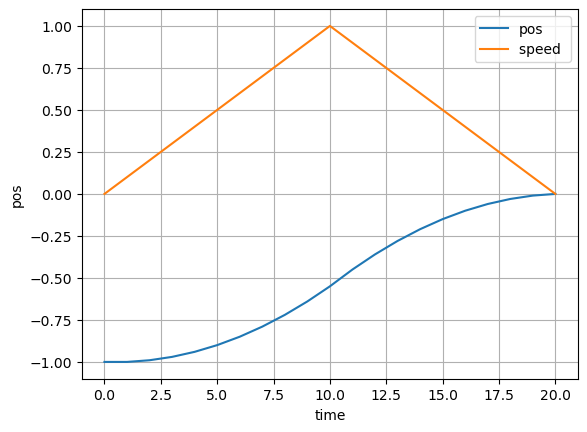

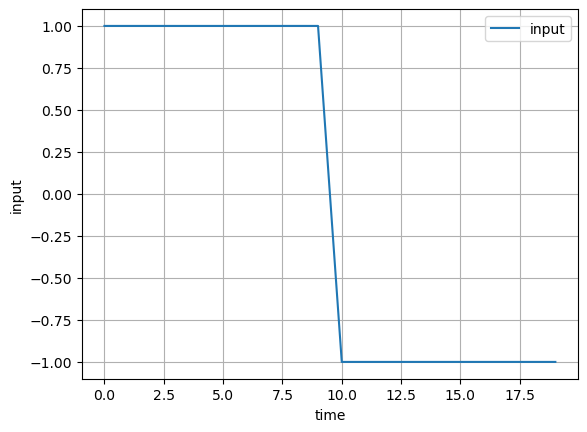

In [130]:
x1 = np.array(x[0, :].value).flatten()
x2 = np.array(x[1, :].value).flatten()
input = np.array(u.value).flatten()
print("error")
print(-x1)

import matplotlib.pyplot as plt
#  flg, ax = plt.subplots(1)

plt.plot(x1, label="pos")
plt.plot(x2,label = "speed ")
plt.xlabel('time')
plt.ylabel('pos')
plt.legend()

plt.grid(True)
plt.show()


# plt.xlabel('time')
# plt.ylabel('speed')
# plt.legend()
# plt.grid(True)

# plt.show()

# plt.plot(input, '*', label="input")
plt.plot((input), label="input")
plt.xlabel('time')
plt.ylabel('input')
plt.legend()
plt.grid(True)

plt.show()

Let's take a look at the inputs and states acheiving this bang bang controller

In [140]:

np.savetxt("../../../Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control/examples/double_integrator/bang_bang_controller.csv", u.value, delimiter=",")
np.savetxt("PytorchRBFLayer/examples/bang_bang_controller.csv", u.value, delimiter=",")
u.value

array([[ 1.0000017554,  1.0000027351,  1.0000037147,  1.0000006425,
         0.9999923041,  0.9999859918,  0.9999823238,  1.0000045269,
         1.0000490281,  1.0000196616, -1.000020029 , -1.0000489197,
        -1.0000045481, -0.9999823273, -0.9999859711, -0.9999923166,
        -1.000000655 , -1.0000036189, -1.0000026393, -1.0000016597]])

In [139]:
np.savetxt("../../../Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control/examples/double_integrator/bang_bang_states.csv", x.value, delimiter=",")
np.savetxt("PytorchRBFLayer/examples/bang_bang_states.csv", x.value, delimiter=",")
(x.value)

array([[-9.9999999917e-01, -9.9999999791e-01, -9.8999997899e-01,
        -9.6999993261e-01, -9.3999984900e-01, -8.9999975888e-01,
        -8.4999974567e-01, -7.8999987248e-01, -7.2000017601e-01,
        -6.4000043424e-01, -5.5000020218e-01, -4.4999977349e-01,
        -3.5999954510e-01, -2.7999980593e-01, -2.1000011226e-01,
        -1.5000024191e-01, -1.0000023133e-01, -6.0000143971e-02,
        -3.0000063241e-02, -1.0000018788e-02, -8.2752668534e-10],
       [ 8.6889681063e-10,  1.0000017753e-01,  2.0000045203e-01,
         3.0000082439e-01,  4.0000088940e-01,  5.0000012045e-01,
         5.9999872015e-01,  6.9999695294e-01,  7.9999740592e-01,
         9.0000230891e-01,  1.0000042751e+00,  9.0000227217e-01,
         7.9999738002e-01,  6.9999692492e-01,  5.9999869178e-01,
         5.0000009414e-01,  4.0000086183e-01,  3.0000079557e-01,
         2.0000043280e-01,  1.0000016787e-01,  7.8607288805e-10]])

In [538]:
import cvxpy
import numpy as np

dt =0.1
A = dt * np.array([[1, 1], [0, 0]])
B = dt* np.array([[0.5*dt], [1]])
(nx, nu) = B.shape

obs_x = 0.8; obs_y = 0.6

gain = 10
alpha = 100
N = 100  # number of horizon
Q = np.eye(nx)
R = np.eye(nu)
P = np.eye(nx)

x0 = np.array([[1.0], [0]])  # init state
max_speed = 1
umax = max_speed*np.array([1,1])
umin = max_speed*np.array([-1,-1])

x0 = np.array([[1], [1]])  # init state

xmin = np.array([[-2], [-2]])   # state constraints
xmax = np.array([[2], [2]])  # state constraints

# xmin = None; xmax = None
(nx, nu) = B.shape

# mpc calculation
x = cvxpy.Variable((nx, N + 1))

u = cvxpy.Variable((nu, N))

gradx = np.array([1,0])
grady = np.array([0,1])

costlist = 0.0
constrlist = []

x1, y1 = -1, 2
x2, y2 = 0.8, 2
x3, y3 = -1, 0.6
x4, y4 = 0.8, 0.6

# Define a small tolerance value (epsilon) to convert strict inequalities to non-strict
epsilon = 1e-6

# Define the constraints for the feasible set



for t in range(N):
    costlist += 0.5 * cvxpy.quad_form(x[:, t], Q)
    costlist += 0.5 * cvxpy.quad_form(u[:, t], R)
    costlist += cvxpy.sum_squares(u[:, t] -(-gain*(x[:,t]-x[:,N]))) 
    

    constrlist += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t]]
    # constrlist += 
#     constrlist += [ x[0, t] >= x1, x[0, t] <= x2, x[1, t] >= y3, x[1, t] <= y1,
#     x[0, t] + epsilon <= x3, x[0, t] >= x4 + epsilon,
#     x[1, t] + epsilon <= y4, x[1, t] >= y2 + epsilon
# ]
    # constrlist.append(u[0,t] >= -1*x[0, t] + 0.6)
    # constrlist.append(u[0,t] >= -10*(x[0, t] - 0.5))
    constrlist.append(u[0,t] >= -alpha*(x[0, t] - obs_x) - (-alpha*(x[1, t] - obs_y)))
    constrlist.append(u[1,t] >= ((-alpha*(x[0, t] - obs_x)) - (-alpha*(x[1, t] - obs_y))) )

    # constrlist.append( x[0, t] >= 0.8 + x[1, t] - 0.6 )
    # constrlist.append( x[1, t] <= 0.6 )

    # constrlist.append(u[1,t] >= (-alpha*(x[0, t] - 0.6)) - (-alpha*(x[1, t] - 0.6)) )
    # constrlist.append(u[0,t] >= (-alpha*(x[0, t] - 0.8)) )
    # constrlist.append(u[0,t] >= (-alpha*(x[0, t] + 0.4)) - (-100*(x[1, t] + 0.2)) )
    # constrlist.append(u[1,t] >= -100*(x[1, t] - 0.6))
    # constrlist.append(u[0,t] >= -10*(x[1, t] - 0.5))
    if xmin is not None:
        constrlist += [x[:, t] >= xmin[:, 0]]
    if xmax is not None:
        constrlist += [x[:, t] <= xmax[:, 0]]

costlist += 0.5 * cvxpy.quad_form(x[:, N], P)  # terminal cost
constrlist += [x[:, N] == [0,0]]
if xmin is not None:
    constrlist += [x[:, N] >= xmin[:, 0]]
if xmax is not None:
    constrlist += [x[:, N] <= xmax[:, 0]]

if umax is not None:
    constrlist += [u[0,:] <= umax[0]]  # input constraints
    constrlist += [u[1,:] <= umax[1]]  # input constraints
if umin is not None:
    constrlist += [u[0,:] >= umin[0]]  # input constraints
    constrlist += [u[1,:] >= umin[1]]  # input constraints

constrlist += [x[:, 0] == x0[:, 0]]  # inital state constraints



IndexError: Index 1 is out of bounds for axis 0 with size 1.

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 08 09:45:19 AM: Your problem has 402 variables, 508 constraints, and 0 parameters.
(CVXPY) Aug 08 09:45:19 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 08 09:45:19 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 08 09:45:19 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 08 09:45:19 AM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 08 09:45:19 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

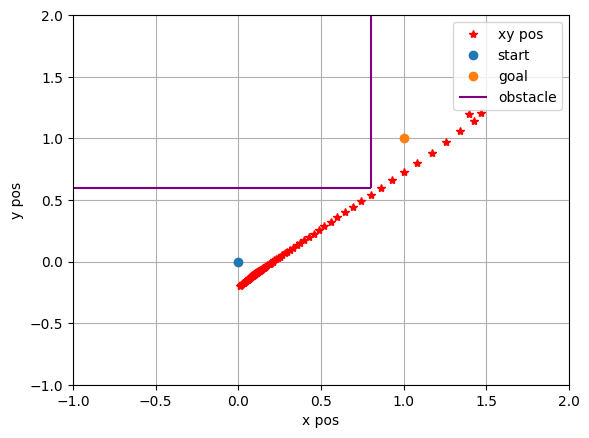

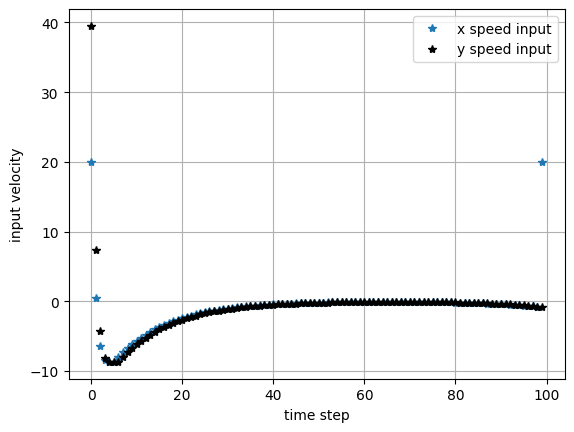

In [17]:
prob = cvxpy.Problem(cvxpy.Minimize(costlist), constrlist)
prob.solve(verbose=True)

x1 = np.array(x[0, :].value).flatten()
x2 = np.array(x[1, :].value).flatten()
u1 = np.array(u[0,:].value).flatten()
u2 = np.array(u[1,:].value).flatten()

import matplotlib.pyplot as plt
#  flg, ax = plt.subplots(1)
plt.plot(x1,x2, '*r', label="xy pos")
plt.plot(0,0, 'o', label="start")
plt.plot(1,1, 'o', label="goal")
plt.vlines(x = obs_x, ymin =obs_y, ymax = 2.5,
           colors = 'purple',
           )
plt.hlines(y = obs_y, xmin = -1, xmax = obs_x,
           colors = 'purple',
           label = 'obstacle')
plt.xlabel('x pos')
plt.ylabel('y pos')
# plt.plot(x2, '*b', label="x2")
# plt.plot(u1, '*k', label="u1")
# plt.plot(u1, '*', label="u2")
plt.xlim([-1,2])
plt.ylim([-1,2])
plt.legend()
plt.grid(True)

plt.show()

plt.plot(u2, '*', label="x speed input")
plt.plot(u1, '*k', label="y speed input")
plt.xlabel('time step')
plt.ylabel('input velocity')
plt.legend()
plt.grid(True)

plt.show()


In [272]:
import numpy as np

dt =0.01
alpha = 10

x = [10]
r = []
r_ = []
x_curr = x[-1]
while(np.linalg.norm(x_curr) >= 1):
    v = -alpha*x_curr
    r_.append(x_curr + dt*v)
    r.append(0 + dt*v)
    x.append(r)
    x_curr = x[-1][-1]
    print(x_curr)
    print('r_',r_)
    print('r',r)



-1.0
r_ [9.0]
r [-1.0]
0.1
r_ [9.0, -0.9]
r [-1.0, 0.1]


In [291]:
uopt = cvxpy.Variable((nu, N))
u_desired = np.vstack((u1,u2))
costlist = 0.0
constrlist = []
x = cvxpy.Variable((nx, N + 1))
for t in range(N):
    costlist += cvxpy.sum_squares(uopt[:, t] - u_desired[:,t]) 
    constrlist.append(uopt[0,t] >= (-alpha*(x[0, t] - 0.8) - (-alpha*(x[1, t] - 0.6))))
    constrlist.append(uopt[1,t] >= ((-alpha*(x[0, t] - 0.8)) - (-alpha*(x[1, t] - 0.6))) )
    constrlist += [x[:, t + 1] == A @ x[:, t] + B @ uopt[:, t]]
    if xmin is not None:
        constrlist += [x[:, t] >= xmin[:, 0]]
    if xmax is not None:
        constrlist += [x[:, t] <= xmax[:, 0]]

constrlist += [x[:, 0] == x0[:, 0]]  # inital state constraints


prob = cvxpy.Problem(cvxpy.Minimize(costlist), constrlist)
prob.solve(verbose=True)

uopt1 = np.array(uopt[0,:].value).flatten()
uopt2 = np.array(uopt[1,:].value).flatten()
uopt_actual = np.vstack((uopt1,uopt2))


print("safe")
print(uopt1,uopt2)
print("desired")
print(u_desired)


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 21 03:24:35 PM: Your problem has 4002 variables, 5001 constraints, and 0 parameters.
(CVXPY) Jul 21 03:24:36 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 21 03:24:36 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 21 03:24:36 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 21 03:24:36 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jul 21 03:24:36 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStu

In [290]:

x_actual = np.zeros((nx, N+1))
x_actual[:,0] = np.array([1,1])
for t in range(N):
    x_actual[:, t + 1] = A @ x_actual[:, t] + B @ uopt_actual[:, t]

import matplotlib.pyplot as plt
#  flg, ax = plt.subplots(1)
plt.plot(x_actual[0,:],x_actual[1,:], '*r', label="xy pos")
plt.plot(0,0, 'o', label="goal")
plt.plot(1,1, 'o', label="start")
plt.vlines(x = 0.8, ymin = 0.6, ymax = 2.5,
           colors = 'purple',
           )
plt.hlines(y = 0.6, xmin = -1, xmax = 0.8,
           colors = 'purple',
           label = 'obstacle')
plt.xlabel('x pos')
plt.ylabel('y pos')
# plt.plot(x2, '*b', label="x2")
# plt.plot(u1, '*k', label="u1")
# plt.plot(u1, '*', label="u2")
plt.xlim([-1,2])
plt.ylim([-1,2])
plt.legend()
plt.grid(True)

plt.show()

plt.plot(uopt2, '*', label="x speed input")
plt.plot(uopt1, '*k', label="y speed input")
plt.xlabel('time step')
plt.ylabel('input velocity')
plt.legend()
plt.grid(True)

plt.show()

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [1]:
import cvxpy as cp

m, n = 3, 2
x = cp.Variable(n, name='x')
A = cp.Parameter((m, n), name='A', sparsity=[(0, 0), (0, 1), (1, 1)])
b = cp.Parameter(m, name='b')
problem = cp.Problem(cp.Minimize(cp.sum_squares(A @ x - b)), [x >= 0])

import numpy as np

np.random.seed(0)
A.value = np.zeros((m, n))
A.value[0, 0] = np.random.randn()
A.value[0, 1] = np.random.randn()
A.value[1, 1] = np.random.randn()
b.value = np.random.randn(m)
problem.solve(verbose=True)

from cvxpygen import cpg

cpg.generate_code(problem, code_dir='nonneg_LS', solver='SCS')

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Aug 02 04:16:11 PM: Your problem has 2 variables, 1 constraints, and 9 parameters.
(CVXPY) Aug 02 04:16:11 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 02 04:16:11 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 02 04:16:11 PM: Compiling problem (target solver=OSQP).
(CVXPY) Aug 02 04:16:11 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Aug 02 04:16:11 PM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 02 04:16:11 PM: Applying reduction Qp2SymbolicQp
(

In [2]:
import time
import sys

# import extension module and register custom CVXPY solve method
from nonneg_LS.cpg_solver import cpg_solve
problem.register_solve('cpg', cpg_solve)

# solve problem conventionally
t0 = time.time()
val = problem.solve(solver='SCS')
t1 = time.time()
sys.stdout.write('\nCVXPY\nSolve time: %.3f ms\n' % (1000*(t1-t0)))
sys.stdout.write('Primal solution: x = [%.6f, %.6f]\n' % tuple(x.value))
sys.stdout.write('Dual solution: d0 = [%.6f, %.6f]\n' % tuple(problem.constraints[0].dual_value))
sys.stdout.write('Objective function value: %.6f\n' % val)

# solve problem with C code via python wrapper
t0 = time.time()
val = problem.solve(method='cpg', updated_params=['A', 'b'], verbose=False)
t1 = time.time()
sys.stdout.write('\nCVXPYgen\nSolve time: %.3f ms\n' % (1000 * (t1 - t0)))
sys.stdout.write('Primal solution: x = [%.6f, %.6f]\n' % tuple(x.value))
sys.stdout.write('Dual solution: d0 = [%.6f, %.6f]\n' % tuple(problem.constraints[0].dual_value))
sys.stdout.write('Objective function value: %.6f\n' % val)


CVXPY
Solve time: 5.494 ms
Primal solution: x = [0.837470, 1.908129]
Dual solution: d0 = [0.000000, 0.000000]
Objective function value: 0.955072

CVXPYgen
Solve time: 0.000 ms
Primal solution: x = [0.837470, 1.908129]
Dual solution: d0 = [0.000000, 0.000000]
Objective function value: 0.955054


35